<a href="https://colab.research.google.com/github/suyeonlee333333/oss2025/blob/main/free_rider_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!apt-get -y install -qq fonts-nanum
!pip install gradio


# 🚇 무임승차 손실 예측 시뮬레이터
기준 연령에 따라 무임인원 → 무임손실액 → 총손실액을 예측하는 모델을 구성합니다.

In [30]:
# 1️⃣ 파일 불러오기
import pandas as pd
file_path = 're_study_data.xlsx'
df = pd.read_excel(file_path)
df.head()

,연도,월,연령,지하철 이용량,고령 인구수,무임인원,무임인원비율,무임손실 (백만),누적손실액
0,2021,1,65,17834292,649577,5419112,0.303859,7586.7568,7586.7568
1,2021,2,65,18431141,652254,5505261,0.298693,7707.3654,15294.1222
2,2021,3,65,23348552,655874,7028495,0.301025,9839.8930,25134.0152
3,2021,4,65,22250031,658150,6783118,0.304859,9496.3652,34630.3804
4,2021,5,65,22606497,660561,6864538,0.303653,9610.3532,44240.7336


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

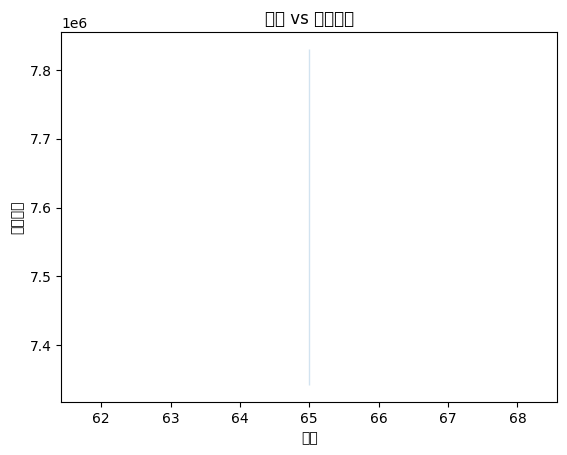

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

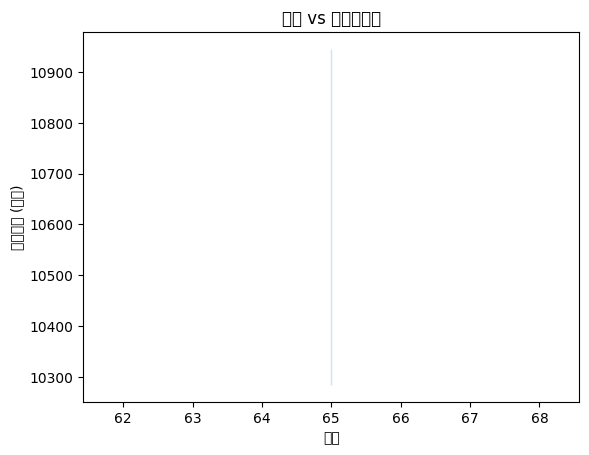

In [31]:

# 2. 런타임 재시작 없이 바로 적용되도록 캐시 재설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# 3. 현재 설치된 폰트 경로 중 나눔 폰트 경로 찾기
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 예시
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
sns.lineplot(data=df, x='연령', y='무임인원')
plt.title('연령 vs 무임인원')
plt.show()

sns.lineplot(data=df, x='연령', y='무임손실 (백만)')
plt.title('연령 vs 무임손실액')
plt.show()

MSE: 549406693380.2131
R² score: -0.10479811147587359


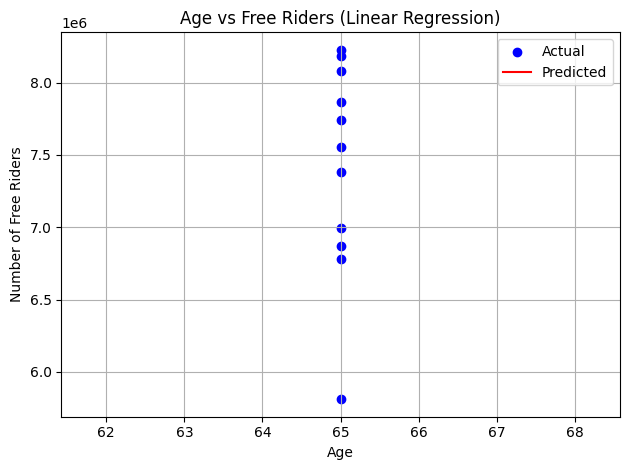

         연령          무임인원
count  52.0  5.200000e+01
mean   65.0  7.588489e+06
std     0.0  8.678786e+05
min    65.0  5.419112e+06
25%    65.0  7.020428e+06
50%    65.0  7.614680e+06
75%    65.0  8.189665e+06
max    65.0  9.620908e+06


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


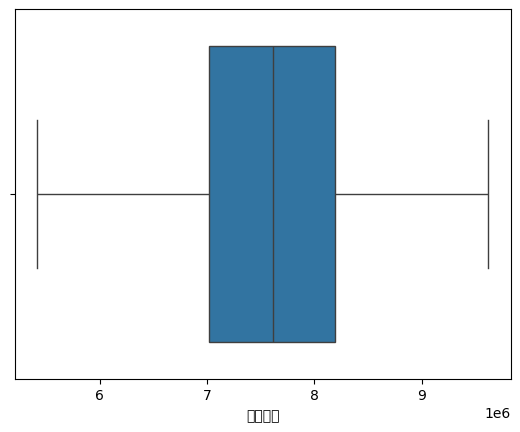

In [32]:
# 3️⃣ 학습 - 연령 -> 무임인원
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df[['연령']]
y = df['무임인원']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 기존 설정 리셋 (폰트 포함)
mpl.rcdefaults()

# 평가 결과 출력
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model_1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R² score:", r2)

# 시각화
plt.scatter(X_test, y_test, label='Actual', color='blue')
plt.plot(X_test, y_pred, label='Predicted', color='red')
plt.xlabel('Age')
plt.ylabel('Number of Free Riders')
plt.title('Age vs Free Riders (Linear Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 통계 및 이상치 시각화
print(df[['연령', '무임인원']].describe())
sns.boxplot(data=df, x='무임인원')
plt.show()




MSE: 3.007929500192828e-25
R² score: 1.0
기울기 (coefficient): [0.0014]
절편 (intercept): 0.0


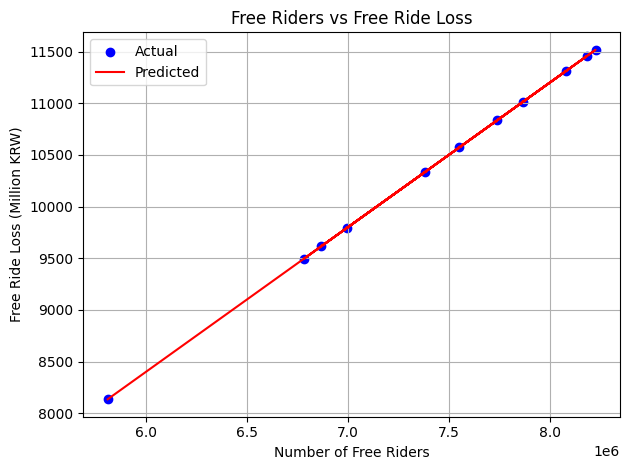

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. 데이터 분할 (학습 80%, 테스트 20%)
X2 = df[['무임인원']]
y2 = df['무임손실 (백만)']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# 2. 모델 생성 및 학습
model_2 = LinearRegression()
model_2.fit(X_train2, y_train2)

# 3. 예측 및 평가
y_pred2 = model_2.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
r2_2 = r2_score(y_test2, y_pred2)

print("MSE:", mse2)
print("R² score:", r2_2)
print("기울기 (coefficient):", model_2.coef_)
print("절편 (intercept):", model_2.intercept_)

# 4. 시각화
plt.scatter(X_test2, y_test2, label='Actual', color='blue')
plt.plot(X_test2, y_pred2, label='Predicted', color='red')
plt.xlabel('Number of Free Riders')
plt.ylabel('Free Ride Loss (Million KRW)')
plt.title('Free Riders vs Free Ride Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[ 19563.78072859  21332.25156194  52601.27269232  47564.16178361
  49235.55547653  51938.89415769  45110.79314665  33653.71988329
  44185.71717788  62514.61619517  62875.12977948  51709.84219471
  49333.08423402  27602.72866885  44314.18170416  62502.95626373
  77806.10307319  69839.82442394  69980.50313896  63358.79112557
  62405.32486599  81171.24550363  76756.91452437  73932.31666188
  58529.21878522  65910.20172124  89649.57578978  80546.96702665
  85500.32349828  84004.46514641  76031.76121803  73563.87925092
  77203.21482255 105818.45198037 100397.83607325  61053.32707664
  60817.21346505  45617.3022105   69744.86167248  70884.55838627
  78531.46166002  67191.70619271  69459.15229618  59864.79413593
  57213.65828161  77286.49711452  73693.39070767  74192.18122536
  55461.19932594  55397.17234328  76331.47072327  81851.2371037 ]


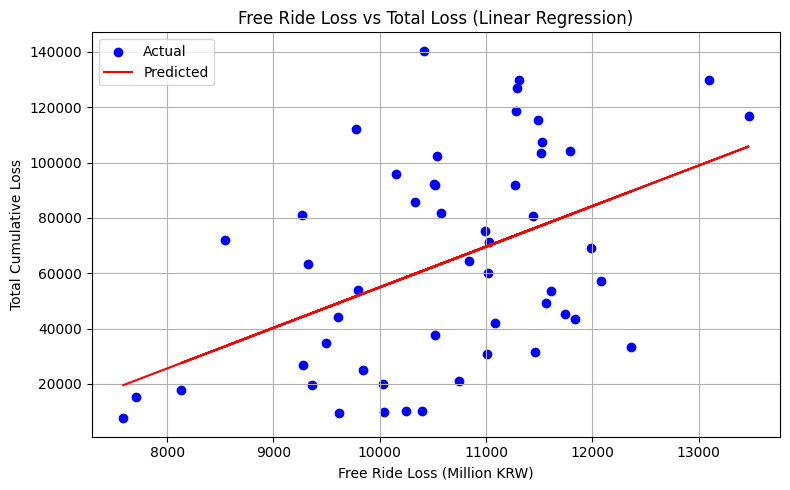

Mean Squared Error (MSE): 1139104589.9715033
R² Score: 0.2146301668018744


In [34]:
# Model: Loss (in million) → Total cumulative loss
X3 = df[['무임손실 (백만)']]
y3 = df['누적손실액']

model_3 = LinearRegression()
model_3.fit(X3, y3)

# Prediction
y_pred = model_3.predict(X3)
print(y_pred)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(X3, y3, label='Actual', color='blue')
plt.plot(X3, y_pred, label='Predicted', color='red')
plt.xlabel('Free Ride Loss (Million KRW)')
plt.ylabel('Total Cumulative Loss')
plt.title('Free Ride Loss vs Total Loss (Linear Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
from sklearn.metrics import mean_squared_error, r2_score
# Evaluation
mse = mean_squared_error(y3, y_pred)
r2 = r2_score(y3, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

In [44]:
# # 6️⃣ 시뮬레이션 함수
# def simulate_loss(age):
#     count = model_1.predict([[age]])[0]
#     loss = model_2.predict([[count]])[0]
#     total = model_3.predict([[loss]])[0]
#     return count, loss, total

# simulate_loss(70)

import pandas as pd

# 반드시 이 줄이 필요합니다!
df = pd.read_excel('re_study_data.xlsx')

X = df[['연령']]
y = df['무임인원']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

import pandas as pd

# 두 번째 시트 불러오기
age_raw = pd.read_excel('re_study_data.xlsx', sheet_name=1)

# 1. 두 번째 열 제거
age_raw = pd.read_excel('re_study_data.xlsx', sheet_name='월별 인구 수')
age_raw.drop(columns=age_raw.columns[1], inplace=True)

# 2. 첫 번째 열 이름 바꾸기
age_raw.rename(columns={age_raw.columns[0]: '연월'}, inplace=True)

# 3. '합'이 들어간 행 제거 + 날짜 파싱
age_raw = age_raw[~age_raw['연월'].astype(str).str.contains('합')]
age_raw['연월'] = pd.to_datetime(age_raw['연월'], errors='coerce')
age_raw = age_raw.dropna(subset=['연월'])
age_raw['연도'] = age_raw['연월'].dt.year


# 연도 필터링
# '연월' 컬럼에 '합'이라는 글자가 포함된 행 제거
age_raw = age_raw[~age_raw['연월'].astype(str).str.contains('합')]

age_raw['연도'] = pd.to_datetime(age_raw['연월']).dt.year
filtered_df = age_raw[(age_raw['연도'] >= 2021) & (age_raw['연도'] <= 2024)]

# 시트 1: 무임 데이터 (연월, 무임인원, 이용량 포함)
summary_df = pd.read_excel('re_study_data.xlsx', sheet_name=0)

# '연월'을 datetime으로 맞춰야 병합이 가능
summary_df['연월'] = pd.to_datetime(summary_df['연월'], errors='coerce')

# 연도 필터링 및 병합
merged_df = pd.merge(filtered_df, summary_df[['연월', '무임인원', '지하철 이용량']], on='연월', how='left')

results = []

for idx, row in merged_df.iterrows():
    연월 = row['연월']
    total_passengers = row['지하철 이용량']
    total_free_riders = row['무임인원']

    # 연령별 고령 인구 추출
    age_data = row.filter(regex=r'^\d+$')
    age_data.index = age_data.index.astype(int)

    # 월별 df 생성
    df_month = pd.DataFrame({
        '연령': age_data.index,
        '고령 인구수': age_data.values,
        '무임인원': [0] * len(age_data),  # simulate_loss 내부에서 다시 계산됨
        '지하철 이용량': total_passengers
    })

    # simulate_loss가 total_free_riders를 받아서 비율로 분배하도록 수정할 수도 있음

    for 기준연령 in range(65, 101, 5):
        count = estimate_free_riders_by_virtual_policy(기준연령, df_month, total_free_riders)
        loss = model_2.predict(pd.DataFrame({'무임인원': [count]}))[0]
        total = model_3.predict(pd.DataFrame({'무임손실 (백만)': [loss]}))[0]

        results.append({
            '연월': 연월,
            '기준연령': 기준연령,
            '무임인원': round(count),
            '무임손실액': round(loss),
            '총손실액': round(total)
        })


results_df = pd.DataFrame(results)
print(results_df.head())


def estimate_free_riders_by_virtual_policy(age, df):
    """
    현재 모든 데이터는 65세 기준이므로,
    기준연령을 상향했을 때 줄어드는 무임인원을 추정한다.

    age: 새 기준 연령 (예: 70세)
    df: 현재 기준 65세로 측정된 고령 인구 분포와 총 무임인원
    """

    # 전체 무임인원: 현재 65세 기준
    total_free_riders = df['무임인원'].sum()

    # 전체 고령 인구수: 65세 이상 인구 전체
    total_old_population = df['고령 인구수'].sum()

    # 기준연령을 age로 올리면 해당 연령 이상의 인구만 무임 가능
    eligible_df = df[df['연령'] >= age]

    if eligible_df.empty:
        return 0  # 기준연령 너무 높아서 대상 없음

    eligible_population = eligible_df['고령 인구수'].sum()

    # 비율 = age 이상 인구수 / 전체 고령 인구수
    eligible_ratio = eligible_population / total_old_population

    # 무임인원 추정
    estimated_free_riders = total_free_riders * eligible_ratio

    return estimated_free_riders

def simulate_loss(age, df):
    count = estimate_free_riders_by_virtual_policy(age, df)

    if count == 0:
        return 0, 0, 0

    loss = model_2.predict(pd.DataFrame({'무임인원': [count]}))[0]
    total = model_3.predict(pd.DataFrame({'무임손실 (백만)': [loss]}))[0]
    return count, loss, total



# def simulate_loss(age):
#     # 연령 → 무임인원 예측 시
#     X1 = pd.DataFrame({'연령': [age]})
#     count = model_1.predict(X1)[0]

#     # 무임인원 → 무임손실액 예측 시
#     X2 = pd.DataFrame({'무임인원': [count]})
#     loss = model_2.predict(X2)[0]

#     # 무임손실액 → 누적손실액 예측 시
#     X3 = pd.DataFrame({'무임손실 (백만)': [loss]})
#     total = model_3.predict(X3)[0]

#     return count, loss, total


KeyError: '연월'

In [38]:
# 7️⃣ Gradio UI
import gradio as gr

def predict_loss(age):
    # 이 df는 전역 변수로 읽어온 엑셀 데이터
    count, loss, total = simulate_loss(age, df)
    return {
        '예상 무임인원': round(count),
        '예상 무임손실액': round(loss),
        '예상 총손실액': round(total)
    }

# def predict_loss(age):
#     count, loss, total = simulate_loss(age)
#     return {
#         '예상 무임인원': round(count),
#         '예상 무임손실액': round(loss),
#         '예상 총손실액': round(total)
#     }

# gr.Interface(fn=predict_loss, inputs=gr.Slider(60, 100, step=1, label='기준 연령'), outputs='json').launch()


for age in range(60, 101, 10):
    print(f"Age {age} → {simulate_loss(age, df)}")

print("Age 60:", simulate_loss(60, df))
print("Age 65:", simulate_loss(65, df))


# 모델 상태 확인
print("모델1 기울기:", model_1.coef_)
print("모델2 기울기:", model_2.coef_)
print("모델3 기울기:", model_3.coef_)


Age 60 → (np.float64(394601440.0), np.float64(552442.016), np.float64(8008717.4089966))
Age 70 → (0, 0, 0)
Age 80 → (0, 0, 0)
Age 90 → (0, 0, 0)
Age 100 → (0, 0, 0)
Age 60: (np.float64(394601440.0), np.float64(552442.016), np.float64(8008717.4089966))
Age 65: (np.float64(394601440.0), np.float64(552442.016), np.float64(8008717.4089966))
모델1 기울기: [0.]
모델2 기울기: [0.0014]
모델3 기울기: [14.66289165]
